ACCESSSING DATASET FROM KAGGLE OPEN SOURCE

In [ ]:
#The data set is large enough, that I found on Kaggle. Instead of storing on local, it was best to drive the data from kaggle directly.
#In the next code snippt, it will load all the images and related caption form kaggle open source.
!mkdir ~/.kaggle

In [ ]:
#Need to download kaggle.json on the current directory
!cp /kaggle/kaggle.json ~/.kaggle/

In [ ]:
#the dataset will be stored as .zip file in the current directory
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d riteshpatil8998/eye-for-blind-dataset

 99% 1.03G/1.04G [00:14<00:00, 87.9MB/s]
100% 1.04G/1.04G [00:14<00:00, 77.5MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile(r'/content/eye-for-blind-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(r'/content/eye-for-blind-dataset/')

In [ ]:
import gc
gc.collect()


0

CHECKING THE SETUP OF PC

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2192885035016580589
xla_global_id: -1
]


IMPORTING IMPORTANT LIBRARIES

In [ ]:
# importing the necessary libraries

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

#importing the libraries for model building
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tqdm import tqdm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Defining paths here. The name of the files are default as picked from the kaggle's dataset
INPUT_PATH = r"/content/eye-for-blind-dataset"
IMAGE_PATH = os.path.join(INPUT_PATH,'Images')
CAPTIONS_FILE = os.path.join(INPUT_PATH,'captions.txt')
OUTPUT_IMAGE_PATH = r"/content/eye-for-blind-dataset/working/Image/"

IMAGE_PATH

'/content/eye-for-blind-dataset/Images'

CHECKING FOR THE IMAGES THAT ARE STORED IN THE DATASET

In [ ]:

all_imgs = glob.glob(IMAGE_PATH + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


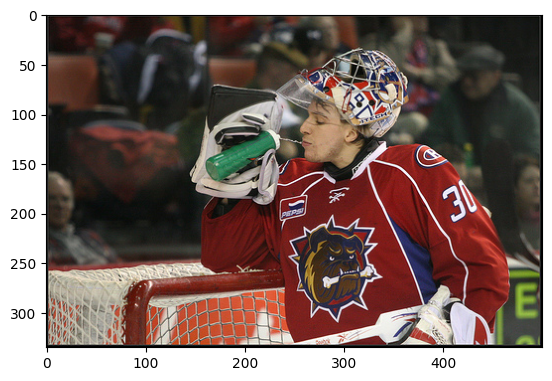

In [ ]:
#Visualise both the images present in the dataset
plt.imshow(mpimg.imread(all_imgs[0]))

CHECKING FOR THE CAPTIONS THAT ARE STORED IN THE DATASET

In [ ]:
##Ding the same for captions. It will pick random captions and publish

def load_doc(filename):

    with open(filename,'r') as f_in:
        text = list(filter(None, (line.rstrip() for line in f_in)))
    f_in.close()

    col=[]
    for line in text:
        col.append(line.split(",",maxsplit=1))

    return col

doc = load_doc(CAPTIONS_FILE)
doc[:45]

[['image', 'caption'],
 ['1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs on pavement moving toward each other .'],
 ['1002674143_1b742ab4b8.

In [ ]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

pd.set_option('display.max_colwidth', None)


def get_thumbnail(path):
    i = Image.open(path)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" style="max-height:124px;">'

GENERATING IDS, PATHS AND CAPTIONS FOR THE IMAGES

In [ ]:
##The provided Python code snippet is designed to process a dataset of images and their associated captions.
# It extracts specific data from the dataset, organizes this data into a structured format using a Pandas DataFrame,
 #and prepares it for further analysis or visualization.
all_img_id = []
all_img_vector = []
annotations = []
image_visual = []
# Extract data from the shuffled list
all_img_id = [i[0] for i in doc[1:]] #store all the image id here
all_img_vector= [os.path.join(IMAGE_PATH,i[0]) for i in doc[1:]] #store all the image path here
annotations= [i[1] for i in doc[1:]] #store all the captions here

df= pd.DataFrame(zip(all_img_id, all_img_vector, annotations), columns=['ID', 'Path', 'Captions'])
df.head()


ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                              Path  \
0  /content/eye-for-blind-dataset/Images/1000268201_693b08cb0e.jpg   
1  /content/eye-for-blind-dataset/Images/1000268201_693b08cb0e.jpg   
2  /content/eye-for-blind-dataset/Images/1000268201_693b08cb0e.jpg   
3  /content/eye-for-blind-dataset/Images/1000268201_693b08cb0e.jpg   
4  /content/eye-for-blind-dataset/Images/1000268201_693b08cb0e.jpg   

                                                                   Captions  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [ ]:
df_img = pd.DataFrame(zip([get_thumbnail(i) for i in df.Path.head().to_list()], df.Captions.head()), columns=['Images', 'Captions'])


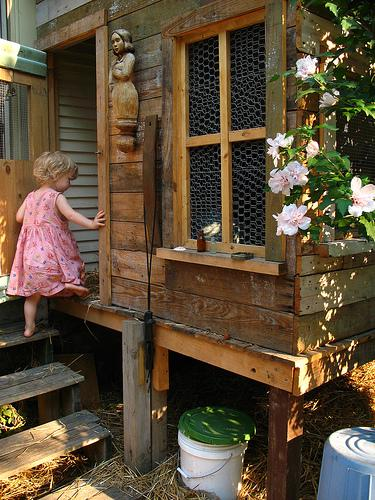
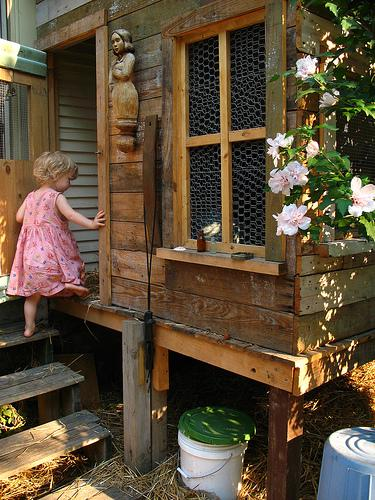
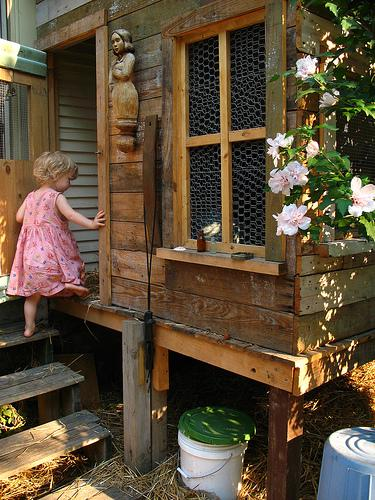
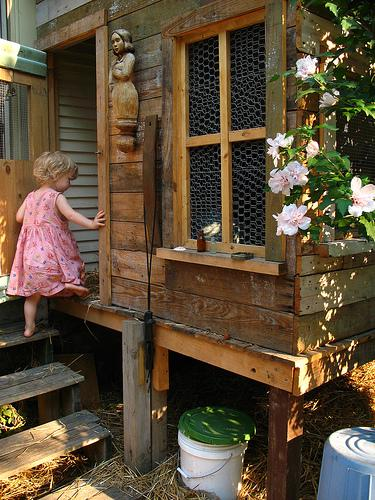
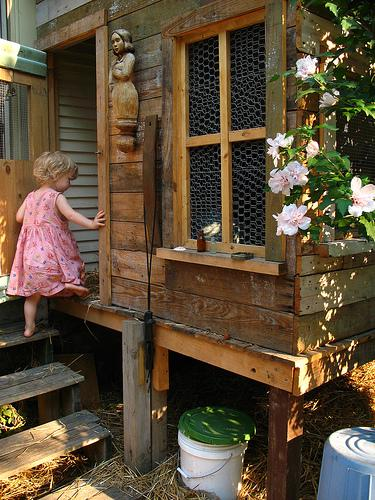

In [ ]:
#Mapping of Image and Caption
HTML(df_img.to_html(formatters={'Images': image_formatter}, escape=False))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [ ]:
#generating a list which will contains all the captions
annotations = []
for cap in df.Captions:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)

all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [ ]:
# Extract vocabulary from captions
vocabulary = []
for cap in df.Captions.values:
        vocabulary.extend(cap.split())

val_count = Counter(vocabulary)
print("Size of Vocab : ",len(set(vocabulary)))

Size of Vocab :  9862


In [ ]:
val_count.most_common(30)

[('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442),
 ('young', 2431),
 ('."', 2365)]

In [ ]:
##Stop words are words that are often removed from text before processing in natural language processing
#tasks because they are considered to be filler words that do not contribute much meaning to the text.
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
sorted_list = val_count.most_common(30)

def plot_word_count(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')


In [ ]:
plot_word_count(sorted_list)

PRE-PROCESING OF THE CAPTIONS STARTS FROM HERE




In [ ]:
# Tokenization of the captions
top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])


[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


In [ ]:
##this code is used to access a slice of the list or array train_seqs, in thi case the first five elements.
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [ ]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
# printing the token

tokenizer.oov_token

'<unk>'

In [ ]:
# Creating word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [ ]:
print(train_seqs[1])
print(annotations[1])

[3, 2, 20, 317, 65, 2, 197, 118, 4]
<start> A girl going into a wooden building . <end>


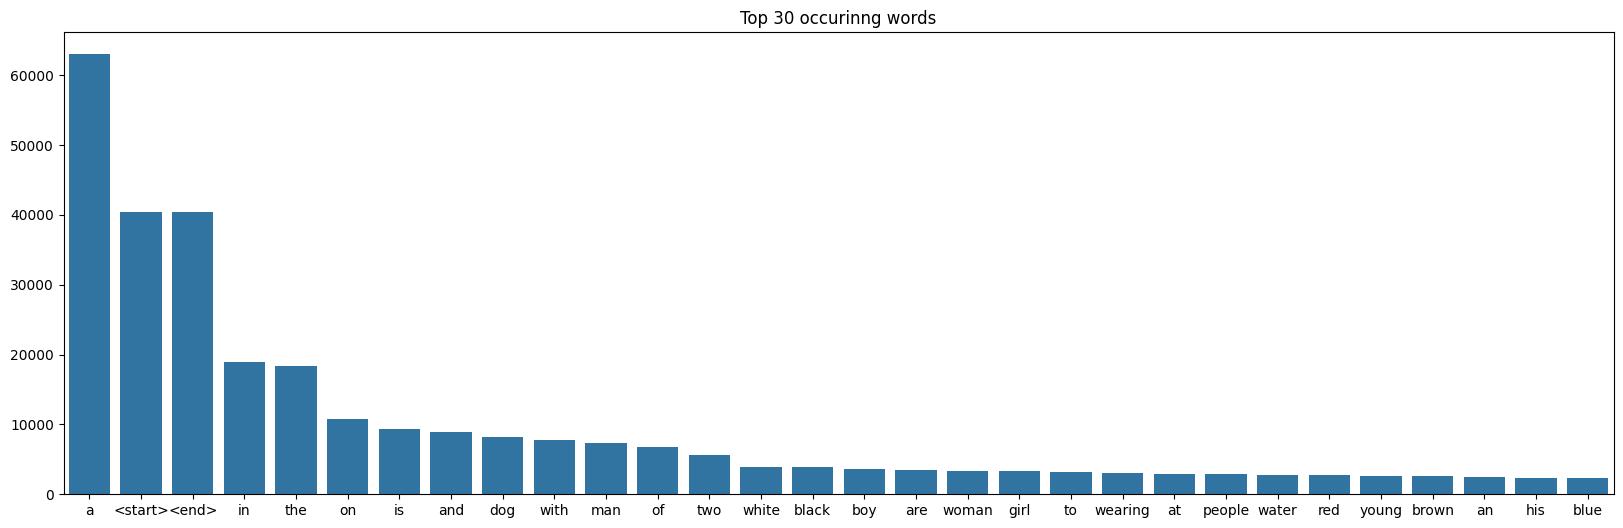

In [ ]:
# generating word count of tokenizer to visulize the Top 30 occuring words after text processing

sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_word_count(sort_word_by_count[:30])

In [ ]:
# Pad each vector to the max_length of the captions store it to a vairable

max_length = max([len(t) for t in train_seqs])
print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

caption_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(caption_vector.shape))



The maximum length of a sentence in the annotation dataset is: 39
The shape of Caption vector is :(40455, 39)


In [ ]:
caption_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [ ]:
print(caption_vector[0])
print(annotations[0])

[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


PRE-PROCESING OF THE IMAGES STARTS FROM HERE

In [ ]:
# write your code here for creating the function. This function should return images & their path
# We will use tensorflow to resize
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image, image_path

Path - /content/eye-for-blind-dataset/Images/1007129816_e794419615.jpg
Shape after resize : (299, 299, 3)


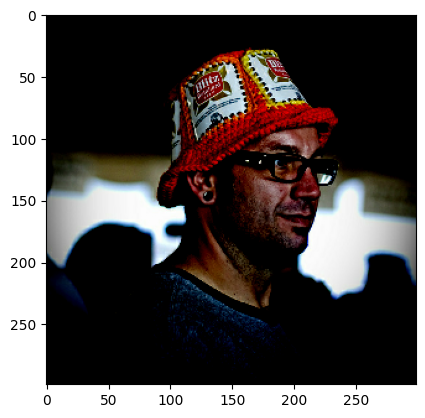

In [ ]:
#Load function test
print("Path -",(all_img_vector[20]))
print("Shape after resize :", load_image(all_img_vector[20])[0].shape)
plt.imshow(load_image(all_img_vector[20])[0])

In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
#Get unique images
all_img_vector_uniq = sorted(set(all_img_vector))

#Updating Batch Size to 64
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector_uniq).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

print("Unique number of Images:", len(all_img_vector_uniq))

Unique number of Images: 8091


In [ ]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)



FROM HERE, INTRODUCING THE INCEPTION NET V3 MODAL

In [ ]:
#Inception V3 Model
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Getting the Pretrained Model Weights
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [ ]:
keras.utils.plot_model(image_model, "image_model.png", show_shapes=True)

In [ ]:
import gc
gc.collect()

96550

In [ ]:
#Writing the code here that will apply the feature extraction model to the dataset previously created, which includes images and their paths.
 #After extracting features, reshaping them to the format (batch_size, 8*8, 2048).

image_dict = {}
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        path_of_feature1 = os.path.basename(path_of_feature)
        path_of_feature2 = './'+path_of_feature1
        np.save(path_of_feature2, bf.numpy())

100%|██████████| 127/127 [39:21<00:00, 18.60s/it]


STARTING DATASET CREATION

In [ ]:
import gc
gc.collect()

0

In [ ]:
len(image_dict)

0

TEST TRAIN SPLIT SY=TARTS FROM HERE

In [ ]:
#APPLYING TEST TRAIN SPLIT
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


[  3 558  10 363 139  40   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> shepherd dog catches tennis ball <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


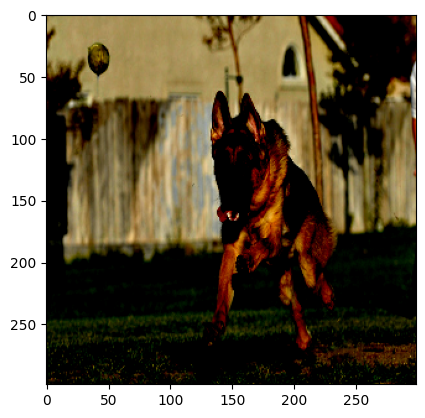

In [ ]:
#CHECKING THE CODE THAT ITS WORKING OR NOT
print(cap_test[5])
print(" ".join(tokenizer.index_word[i] for i in cap_test[5]))
plt.imshow(load_image(path_test[5])[0])


In [ ]:
# mapping the image path to their feature by creating a function
#The function will take an image path and its corresponding caption as inputs and return the extracted
#features of the image along with the respective caption.

def map_func(image, caption):
    img_name_temp = os.path.basename(image.numpy().decode('utf-8'))
    img_name_ip = './'+img_name_temp
    img_tensor = np.load(img_name_ip+'.npy')
    return img_tensor, caption

In [ ]:
# Defining a builder function that constructs a dataset using image paths and captions as inputs.
#This function will convert the dataset from (image_path, caption) format to (features, caption) using a previously defined mapping function (map_func).

def data_generator(image,caption, batch_size=32, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    dataset = dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_dataset=data_generator(path_train,cap_train,64)
test_dataset=data_generator(path_test,cap_test,64)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 39)


MODAL BUILDING STARTS FORM HERE

In [ ]:
#SETTING THE PARAMETERS
BATCH_SIZE = 32
embedding_dim = 256
units = 512
vocab_size = 5001
train_num_steps = len(path_train)
test_num_steps = len(path_test)
#  two variables which will represent the vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

INTRODUCING ENCODER

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, features):
        features =  self.dense(features)
        features = tf.nn.relu(features)

        return features

In [ ]:
encoder=Encoder(embedding_dim)

INTRODUCTION ATTENTION MODEL MECHANISM

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis = 1)


        return context_vector, attention_weights

INTRODUCING DECODER HERE

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.5)


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.dropout(self.embed(x))
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed, mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))


Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


OPTOMIZATION STARTS HERE\


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])



In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss



In [ ]:
   print(tf.__version__)

2.15.0


In [ ]:

@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            predicted_id = tf.argmax(predictions,1)

            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss



In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 12.1 MiB
                caption_vector:  6.0 MiB
                           _34:  6.0 MiB
                     cap_train:  4.8 MiB
                    vocabulary:  3.9 MiB
                      cap_test:  1.2 MiB
                           doc: 342.8 KiB
                    all_img_id: 342.8 KiB
                all_img_vector: 342.8 KiB
                   annotations: 342.8 KiB
                    train_seqs: 342.8 KiB
                  all_img_path: 316.1 KiB
                     val_count: 288.1 KiB
                    word_index: 288.1 KiB
                    index_word: 288.1 KiB
                    path_train: 270.8 KiB
            sort_word_by_count: 66.4 KiB
                      all_imgs: 65.6 KiB
                     path_test: 65.6 KiB
                 uni_filenames: 63.3 KiB


In [ ]:
del df
del caption_vector
gc.collect()

22

In [ ]:
import psutil
process = psutil.Process(os.getpid())
process.memory_info()

pmem(rss=1518137344, vms=4034150400, shared=376696832, text=2818048, lib=0, data=1570320384, dirty=0)

In [ ]:
tf.executing_eagerly()

True

MODAL TRAINING FROM HERE

In [ ]:


loss_plot = []
test_loss_plot = []
EPOCHS = 4

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f} and time taken is {}'.format(epoch+1,avg_train_loss,test_loss,time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/4 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.494, & test loss is 0.971 and time taken is 3319.173595190048
Test loss has been reduced from 100.000 to 0.971


 25%|██▌       | 1/4 [55:19<2:45:58, 3319.64s/it]

For epoch: 2, the train loss is 0.449, & test loss is 0.963 and time taken is 3234.121114253998
Test loss has been reduced from 0.971 to 0.963


 75%|███████▌  | 3/4 [2:44:51<55:00, 3300.64s/it]  

For epoch: 3, the train loss is 0.419, & test loss is 0.981 and time taken is 3337.4457890987396


100%|██████████| 4/4 [3:38:33<00:00, 3278.30s/it]

For epoch: 4, the train loss is 0.393, & test loss is 0.964 and time taken is 3221.3110432624817


In [ ]:
gc.collect()

1860

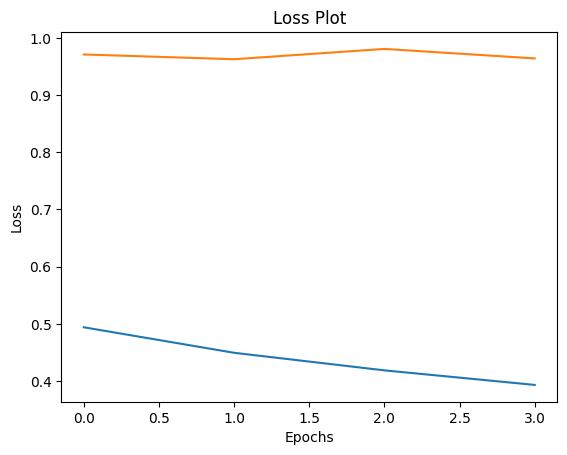

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

GREEDY SEARCH IMPLEMENTATION

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()


        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def Testing_Model(img_test):
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]


    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attmap(result, attention_plot, test_image)

    return test_image, pred_caption

In [ ]:
from PIL import Image
def Prediction_Unknown_data(test_image):
    openImg = test_image
    print(test_image)
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))

    return im


/content/eye-for-blind-dataset/Images/3485816074_363cab4bff.jpg
dec_input Shape (1, 1)
Prediction Caption: three men in white playing rugby ball as other game

500 333


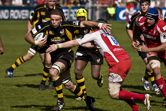

In [ ]:
Prediction_Unknown_data(path_test[10])

/content/eye-for-blind-dataset/Images/270263570_3160f360d3.jpg
dec_input Shape (1, 1)
Prediction Caption: two large brown dogs play together

500 461


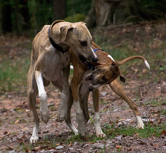

In [ ]:
Prediction_Unknown_data(path_test[1])

dec_input Shape (1, 1)
Real Caption      : a white racing dog with a muzzle is racing around the turn of a dirt track
Prediction Caption: a <unk> with the number fast around each other is running through the white uniform racing each other side of some horse with muzzles round white obstacle toy in the <unk> a wooden track crowd along on a


BELU score: 
Individual 1-gram: 28.947368421052634
Individual 2-gram: 2.2250738585072627e-306
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

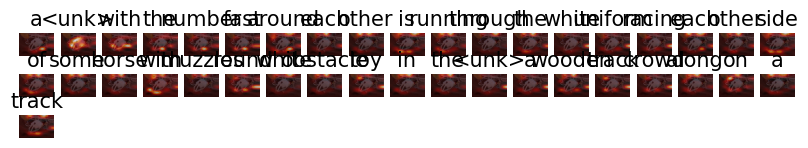

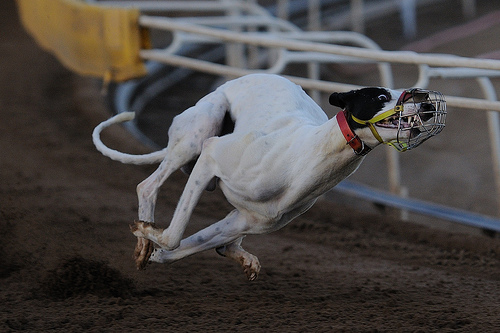

In [ ]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

dec_input Shape (1, 1)
Real Caption      : a woman holding a drink and smiling
Prediction Caption: person is blindfolded by something in her


BELU score: 
Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


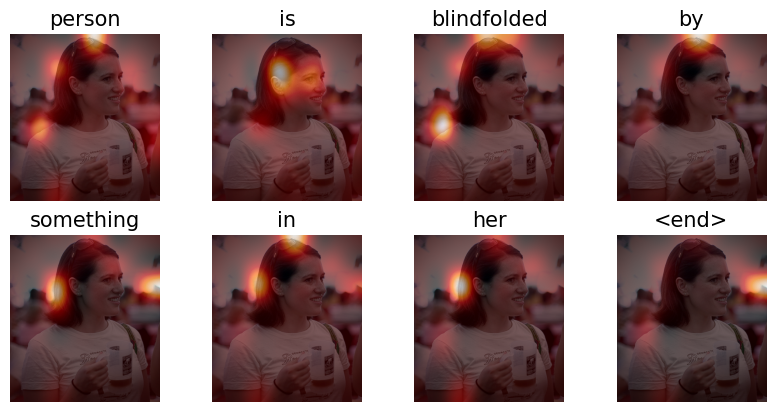

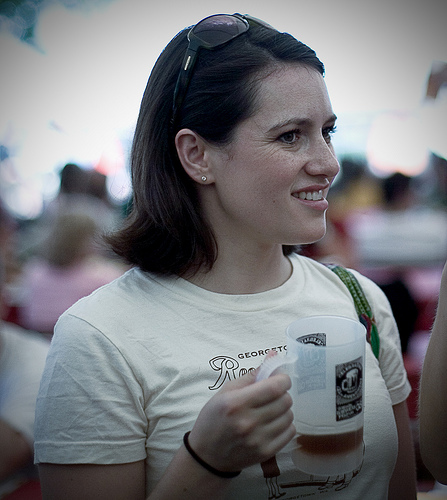

In [ ]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

In [ ]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a girl is smiling


CONVERTING TO AUDIO OF THE CAPTIONS

In [ ]:
 !pip install gTTS

In [ ]:

from gtts import gTTS
from IPython import display

In [ ]:
#Caption to audio conversion
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))